In [63]:
import math

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from datasets import Dataset

In [2]:
# import torch.cuda

# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device

## Reading in Data

In [3]:
original_df = pd.read_csv("malicious_phish.csv")
original_df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
len(original_df)

651191

In [5]:
original_df["url"][:5]

0                                     br-icloud.com.br
1                  mp3raid.com/music/krizz_kaliko.html
2                      bopsecrets.org/rexroth/cr/1.htm
3    http://www.garage-pirenne.be/index.php?option=...
4    http://adventure-nicaragua.net/index.php?optio...
Name: url, dtype: object

## Sampling the Data

In [6]:
# PERCENTAGE = 0.005
# df = original_df.sample(frac=PERCENTAGE, replace=False, random_state=42)

In [7]:
NUM_SAMPLES = 1000
df = original_df.sample(n=NUM_SAMPLES, replace=False, random_state=42)

In [8]:
df.shape

(1000, 2)

## BERT Setup

In [9]:
MODEL = "./bert-base-uncased/"

In [10]:
METRIC = "accuracy"

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./bert-base-uncased/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Loading Dataset

In [13]:
dataset = Dataset.from_pandas(df)

In [14]:
dataset = dataset.remove_columns(["__index_level_0__"])

In [15]:
dataset = dataset.class_encode_column("type")

Casting to class labels: 100%|███| 1000/1000 [00:00<00:00, 214006.02 examples/s]


In [16]:
dataset = dataset.rename_column("url", "text")
dataset = dataset.rename_column("type", "label")

In [17]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

## BERT Tokenization

In [18]:
def tokenize(data):
    return tokenizer(data["text"], padding="max_length", return_tensors="pt")

In [19]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|█████████████████████████| 1000/1000 [00:00<00:00, 1853.14 examples/s]


In [20]:
tokenized_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

## Dataset Split

In [28]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1)

In [29]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 900
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})

In [30]:
train_eval_dataset = split_dataset["train"]

In [33]:
train_eval_split_dataset = train_eval_dataset.train_test_split(test_size=0.1)

In [34]:
train_dataset = train_eval_split_dataset["train"]

In [35]:
eval_dataset = train_eval_split_dataset["test"]

In [36]:
test_dataset = split_dataset["test"]

In [41]:
train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 810
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 90
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 100
 }))

## BERT Fine-Tuning

In [42]:
training_args = TrainingArguments(output_dir="results", 
                                  num_train_epochs=5,
                                  logging_steps=1,
                                  learning_rate=5e-7,
                                  per_device_train_batch_size=8,
                                  evaluation_strategy="epoch")

Cross-Entropy Loss

In [44]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sum = 0
    for i in range(len(labels)):
        raw_logits = logits[i]
        
        exp_logits = np.exp(raw_logits)
        norm_logits = exp_logits / np.sum(exp_logits, axis=0)
        chosen_value = norm_logits[labels[i]]
        
        sum += np.log(chosen_value)
    sum /= -len(labels)
    return {"cross_entropy": sum}

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,Cross Entropy
1,1.242000,1.194389,1.194389
2,0.802500,1.153727,1.153727
3,0.772200,1.126958,1.126958
4,0.977700,1.109622,1.109622
5,1.219000,1.103828,1.103828


TrainOutput(global_step=510, training_loss=1.1279195351927889, metrics={'train_runtime': 253.3571, 'train_samples_per_second': 15.985, 'train_steps_per_second': 2.013, 'total_flos': 1065618909388800.0, 'train_loss': 1.1279195351927889, 'epoch': 5.0})

## Predictions

In [52]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)

In [55]:
true_labels = test_dataset["label"]

In [56]:
target_labels = ["benign", "defacement", "malware", "phishing"]

In [59]:
conf_mat = confusion_matrix(true_labels, predicted_labels, labels=np.arange(4))

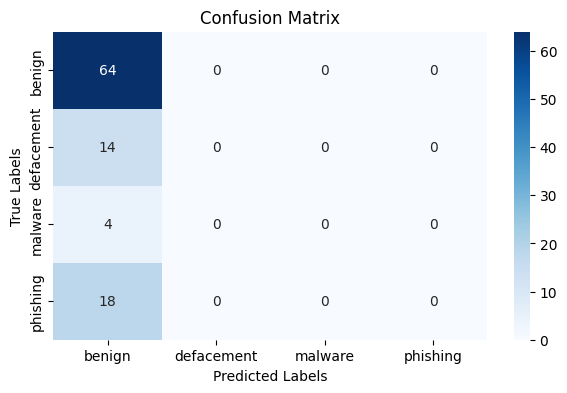

In [64]:
plt.figure(figsize=(7, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [65]:
report = classification_report(true_labels, predicted_labels, labels=np.arange(4), target_names=target_labels, output_dict=False)
print(report)

              precision    recall  f1-score   support

      benign       0.64      1.00      0.78        64
  defacement       0.00      0.00      0.00        14
     malware       0.00      0.00      0.00         4
    phishing       0.00      0.00      0.00        18

    accuracy                           0.64       100
   macro avg       0.16      0.25      0.20       100
weighted avg       0.41      0.64      0.50       100



/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f